Paul Abers <br>
CS 637 <br>
Homework 2 <br>
CNN From Scratch Using PyTorch <br>

First, lets make the necessary imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision.transforms import ToTensor
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

from read_cifar import load, normalize

%matplotlib inline

Next, we need to load in all of our data. Note that PyTorch expects images to be of size Channels X width X height so we need to swap the axes from the return on the call to load. The input data is also normalized to min max [0,1].

In [2]:
Xtr_, Ytr_, Xte, Yte = load(r'data/cifar-10-batches-py')

In [3]:
Xtr_ = Xtr_.swapaxes(1,3).swapaxes(2,3)
Xte = Xte.swapaxes(1,3).swapaxes(2,3)
Xtr_, Xte = normalize(Xtr_), normalize(Xte)

Now we can create our CNN. Our input image is of size 3 x 32 x 32. Our first convulational layer will be 32 3x3 filters with a stride of 1 and a padding of 1. This will keep the size of the images the same, but the number of channels changes. Output shape is 32 x 32 x 32. We then use batch normalization and a relu activation. This is then fed into a 64 x 32 x 32 with stride of 3 and padding of 1. Finally max pooling is done with size 2 x 2 which results in a size of 64 x 16 x 16.
<br><br>
Our first convolutional block will then feed into a another convolutional block that folows the same strategy, but the output channels for the two layers are 128 (we also repeat the max pool 2 x 2) which results in a final size of 128 x 8 x 8. A Dropout with percentage 5 % is applied to the output of the second convolutional block.
<br><br>
The final convolutional block uses output channel sizes of 256. The max pooling is 2 x 2. This results in a final size of 256 x 4 x 4. This results in a total of 4096 nodes out of the convolutional portion of our neural network.
<br><br>
We then use a multi layer perceptron to learn the outputs from the convolutions. The first hidden layer is 1024 nodes. The second is 512 nodes and the final output is equal to the number of outputs which is 10. Every layer uses a RELU activation and the final output uses a soft max activation. There is a 10% dropout on the inputs into the neural network and on the second hidden layer.

In [4]:
class CNN(nn.Module):
    def __init__ (self):
        super().__init__()
        self.conv = nn.Sequential(

            # Conv 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )

    def forward(self,x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

Now, we convert our input numpy arrays to the torch tensor datatype and then load it into the dataloader type with the given batch size. We also create a validation dataset that is a subset of the training dataset.

In [5]:
size = Xtr_.shape[0]
num_val = int((1-0.25) * size)
Xtr = Xtr_[:num_val]
Xva = Xtr_[num_val:]
Ytr = Ytr_[:num_val]
Yva = Ytr_[num_val:]

In [6]:
Xtr = torch.Tensor(Xtr)
Xva = torch.Tensor(Xva)
Xte = torch.Tensor(Xte)
Ytr = torch.Tensor(Ytr).type(torch.LongTensor)
Yva = torch.Tensor(Yva).type(torch.LongTensor)
Yte = torch.Tensor(Yte).type(torch.LongTensor)

train_dataset = TensorDataset(Xtr, Ytr)
val_dataset = TensorDataset(Xva, Yva)
test_dataset = TensorDataset(Xte, Yte)

In [7]:
# Create data loaders.
batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

We next create several functions to facilitate training, validating and testing our model. We also use the save and load model states so we can use model selection later based on the training and validating performances vs epochs.

In [8]:
def save_model_state(model, epoch, model_name):
    """Saves current model state to temp folder to be loaded later during model selection"""
    # save model checkpoint
    torch.save({
                'model_state_dict': model.state_dict(),
                }, f"./temp/model_{model_name}_{epoch}.pth")

In [9]:
def load_state_epoch(model, epoch, model_name):
    """Loads a specified model state from temp folder"""
    # load the model checkpoint
    checkpoint = torch.load(f"./temp/model_{model_name}_{epoch}.pth")
    # load model weights state_dict
    model.load_state_dict(checkpoint['model_state_dict'])
    print('Previously trained model weights state_dict loaded...')
    return model

In [10]:
def train(dataloader, model, loss_fn, optimizer):
    """Train the model using the loss funciton and optimizer provided.
    
    Loop over each batch and train the model."""
    size = len(dataloader.dataset)
    tr_loss, tr_correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        tr_loss += loss_fn(pred, y).item()
        tr_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    tr_loss /= size
    tr_correct /= size
    return tr_loss, tr_correct

In [11]:
def test(dataloader, model):
    """"Get the performance for the model's current state."""
    size = len(dataloader.dataset)
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

We now initialize our network and choose a loss function and optimizer.

In [12]:
device = "cpu"
model = CNN().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)

Now run the model over the specified number of epochs for training.

In [ ]:
epochs = 100
tr_acc, tr_loss = [], []
val_acc, val_loss = [], []
for t in range(1, epochs+1):
    print(f"Epoch {t}\n-------------------------------")
    tl, ta = train(train_dataloader, model, loss_fn, optimizer)
    print("Val Error:")
    vl, va = test(val_dataloader, model)
    tr_acc.append(ta)
    tr_loss.append(tl)
    val_acc.append(va)
    val_loss.append(vl)
    if t % 1 == 0:
        save_model_state(model, t, "simple")
print("Done!")

Plot the accuracy and loss of the model (both train and validate) vs epoch to help with model selection.

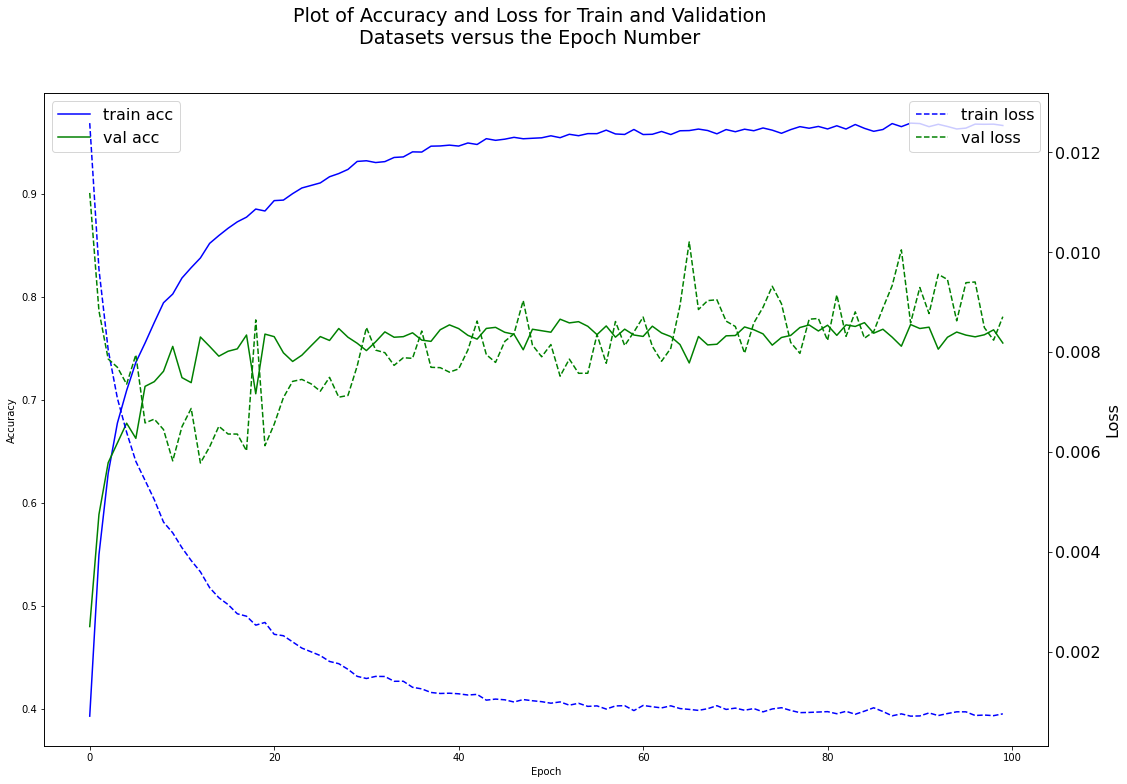

In [14]:
fig, ax = plt.subplots(figsize=(18,12))
plt.rcParams['font.size'] = '16'
ax.plot(tr_acc, 'b', label="train acc")
ax.plot(val_acc, 'g', label="val acc")
ax.set_ylabel("Accuracy")
plt.legend()
ax2=ax.twinx()
ax2.plot(tr_loss, 'b--', label="train loss")
ax2.plot(val_loss, 'g--', label="val loss")
ax2.set_ylabel("Loss")
ax.set_xlabel("Epoch")
fig.suptitle("Plot of Accuracy and Loss for Train and Validation\nDatasets versus the Epoch Number")
plt.legend()

Select the epoch of choice for the model.

In [17]:
final_model = load_state_epoch(model, 12, "simple")

Previously trained model weights state_dict loaded...


Check the model's performance with the test dataset.

In [18]:
print("Train Error:")
_ = test(train_dataloader, final_model)
print("Val Error:")
_ = test(val_dataloader, final_model)
print("Test Error:")
_ = test(test_dataloader, final_model)

Train Error:
Accuracy: 78.1%, Avg loss: 0.004857 

Val Error:
Accuracy: 71.7%, Avg loss: 0.006875 

Test Error:
Accuracy: 70.9%, Avg loss: 0.007106 

